$
\newcommand{\Tau}{\mathcal{T}}
\newcommand{\bm}[1]{{\boldsymbol{#1}}}
\newcommand{\dt}[1]{{\frac{d#1}{dt}}}
%\newcommand{\bm}{\mathbf{#1}}
\newcommand{\trsp}{{\scriptscriptstyle\top}}$

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pbdlib as pbd

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Hidden Markov Model and LQR
This is an example of learning a HMM over some trajectories demonstrations and reproducing it using optimal control.
More infos : http://calinon.ch/papers/Calinon-JIST2015.pdf, http://calinon.ch/papers/Calinon-HFR2016.pdf


## Learning Hidden Markov Model (HMM)

In [2]:
from scipy.io import loadmat # loading data from matlab

letter = 'C' # choose a letter in the alphabet

datapath = os.path.dirname(pbd.__file__) + '/data/2Dletters/'
data = loadmat(datapath + '%s.mat' % letter)

demos_x = [d['pos'][0][0].T for d in data['demos'][0]] # Position data
demos_dx = [d['vel'][0][0].T for d in data['demos'][0]] # Velocity data
demos_xdx = [np.hstack([_x, _dx]) for _x ,_dx in zip(demos_x, demos_dx)] # Position-velocity

EM did not converge


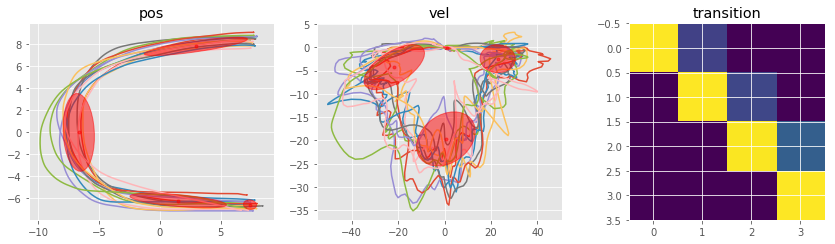

In [3]:
model = pbd.HMM(nb_states=4, nb_dim=4)

model.init_hmm_kbins(demos_xdx) # initializing model

# EM to train model
model.em(demos_xdx, reg=1e-3) 


# plotting
fig, ax = plt.subplots(ncols=3)
fig.set_size_inches(12,3.5)

# position plotting
ax[0].set_title('pos')
for p in demos_x:
    ax[0].plot(p[:, 0], p[:, 1])
    
pbd.plot_gmm(model.mu, model.sigma, ax=ax[0], dim=[0, 1]); 

# velocity plotting
ax[1].set_title('vel')
for p in demos_dx:
    ax[1].plot(p[:, 0], p[:, 1])
    
pbd.plot_gmm(model.mu, model.sigma, ax=ax[1], dim=[2, 3]); 


# plotting transition matrix
ax[2].set_title('transition')
ax[2].imshow(np.log(model.Trans+1e-10), interpolation='nearest', vmin=-5, cmap='viridis');
plt.tight_layout()

# Reproduction (LQR) 
Using Product of Gaussian formulation with augmented transfer matrices see : http://calinon.ch/papers/Calinon-HFR2016.pdf

### Get sequence of states 

/home/pignate/code/pbdlib/public/pbdlib/pbdlib/hmm.py:95: RuntimeWarning: divide by zero encountered in log
  logDELTA[:, 0] = np.log(self.init_priors + realmin * reg) + logB[:, 0]
/home/pignate/code/pbdlib/public/pbdlib/pbdlib/hmm.py:100: RuntimeWarning: divide by zero encountered in log
  PSI[i, t] = np.argmax(logDELTA[:, t - 1] + np.log(self.Trans[:, i] + realmin * reg))
/home/pignate/code/pbdlib/public/pbdlib/pbdlib/hmm.py:101: RuntimeWarning: divide by zero encountered in log
  logDELTA[i, t] = np.max(logDELTA[:, t - 1] + np.log(self.Trans[:, i] + realmin * reg)) + logB[i, t]


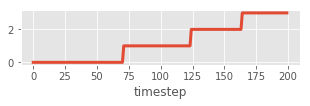

In [4]:
demo_idx = 0
sq = model.viterbi(demos_xdx[demo_idx])

plt.figure(figsize=(5, 1))
# plt.axis('off')
plt.plot(sq, lw=3);
plt.xlabel('timestep');

## Create and solve LQR 

In [5]:
lqr = pbd.PoGLQR(nb_dim=2, dt=0.01, horizon=demos_xdx[demo_idx].shape[0])
lqr.mvn_xi = model.concatenate_gaussian(sq)
lqr.mvn_u = -4.
lqr.x0 = demos_xdx[demo_idx][0]

xi = lqr.seq_xi

## Plotting reproduced trajectory (position and velocity)

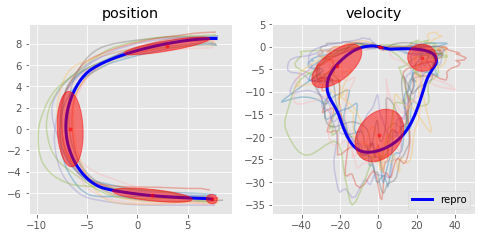

In [6]:
fig, ax = plt.subplots(ncols=2)
fig.set_size_inches(8,3.5)


# position plotting 
ax[0].set_title('position')
for p in demos_x:
    ax[0].plot(p[:, 0], p[:, 1], alpha=0.4)
    
ax[0].plot(xi[:, 0], xi[:, 1], 'b', lw=3)
pbd.plot_gmm(model.mu, model.sigma, ax=ax[0], dim=[0, 1]); 

# velocity plotting
ax[1].set_title('velocity')
for p in demos_dx:
    ax[1].plot(p[:, 0], p[:, 1], alpha=0.4)
    
ax[1].plot(xi[:, 2], xi[:, 3], 'b', lw=3, label='repro')

plt.legend()
pbd.plot_gmm(model.mu, model.sigma, ax=ax[1], dim=[2, 3]); 
